# Sin波形を予測する

###①ライブラリインポート

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###②パラメータ設定

In [76]:
# 必要情報の入力
seq_length = 50 #周期性がどの程度あるのか？ここをよく見ながら設定すること！！
num_test = 25 # 予測区間
hidden_size = 300 # 隠れ層数の設定
num_epochs = 200 # エポック数の設定
learningrate=0.001 # 学習率の設定
# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)

plt.style.use("ggplot")
%matplotlib inline

###③教師データ準備

In [77]:
# sin波形の作成
x = np.linspace(0,499,500)
ori_y = np.sin(x * 2 * np.pi / 50)

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ori_y.reshape(-1, 1))
print(scaled_data.size)

y = scaled_data
y = y.squeeze()
allsize = y.shape[0]
x = np.linspace(0,allsize-1,allsize)
print(y.shape)

500
(500,)


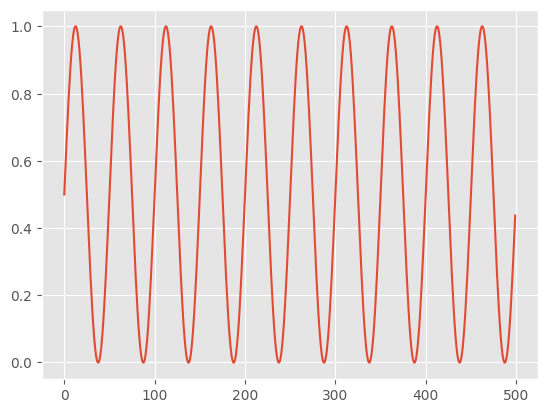

In [78]:
plt.plot(x,y)

###④Window sizeの設定

In [79]:
def make_sequence_data(y, num_sequence):
  num_data = len(y)
  seq_data = [] # 刻みのデータを格納する用のリスト
  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  target_arr = np.array(target_data)
  #return seq_arr, target_arr
  return seq_arr.squeeze(), target_arr.squeeze()

In [80]:
y_seq, y_target = make_sequence_data(y , seq_length)
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [81]:
y_seq_train.shape

(425, 50)

###⑤pyTorch用にデータ変換

In [82]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)
print(f"y_set_t:{y_seq_t.shape} y_target_t:{y_target_t.shape}")

y_set_t:torch.Size([425, 50]) y_target_t:torch.Size([425])


###⑥LSTM定義

In [83]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1] #予測の末尾を取得
    x = self.linear(x_last)
    return x

In [84]:
model = LSTM(hidden_size)

In [85]:
# Loss関数と最適化アルゴリズムの設定
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learningrate)

###⑦LSTMに入力するための処理

In [86]:
y_seq_t = y_seq_t.permute(1,0)
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、
#最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [87]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)
# 30×460の2次元テンサーなので、1次元にする必要がる
# unsqueezeはsqueezeの反対なのでsqueezeは40x450x1を絞って40x450にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [88]:
y_seq_t.shape

torch.Size([50, 425, 1])

###⑧学習トレーニング


In [89]:
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))
#ミニバッチのランニングLossを初期化することが通常だが
#今回はバッチ学習のためいきなりOptimizerの初期化を実施します

epoch: 0, loss: 0.3579811453819275
epoch: 10, loss: 0.09600427746772766
epoch: 20, loss: 0.07603011280298233
epoch: 30, loss: 0.05366671457886696
epoch: 40, loss: 0.027608651667833328
epoch: 50, loss: 0.012086068280041218
epoch: 60, loss: 0.004563047084957361
epoch: 70, loss: 0.0013396815629675984
epoch: 80, loss: 0.0004440945340320468
epoch: 90, loss: 0.00014275613648351282
epoch: 100, loss: 0.00010616626968840137
epoch: 110, loss: 7.693679071962833e-05
epoch: 120, loss: 5.136022809892893e-05
epoch: 130, loss: 4.165484642726369e-05
epoch: 140, loss: 3.577194001991302e-05
epoch: 150, loss: 3.008017665706575e-05
epoch: 160, loss: 2.5761930373846553e-05
epoch: 170, loss: 2.220121859863866e-05
epoch: 180, loss: 1.9129516658722423e-05
epoch: 190, loss: 1.6516254618181847e-05


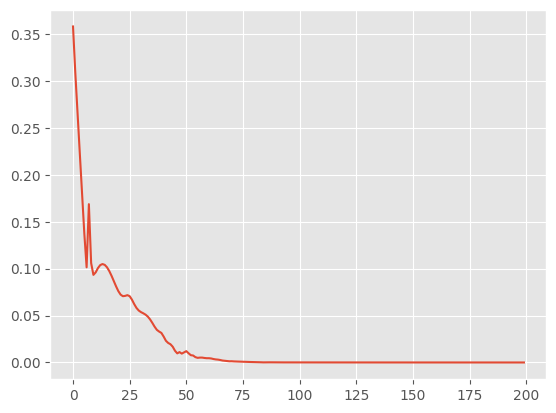

In [90]:
# Loss関数の推移を確認
plt.plot(losses)

###⑨テストデータでの予測精度確認

In [91]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)
y_seq_test_t.size()
y_pred = model(y_seq_test_t)

(250.0, 525.0)

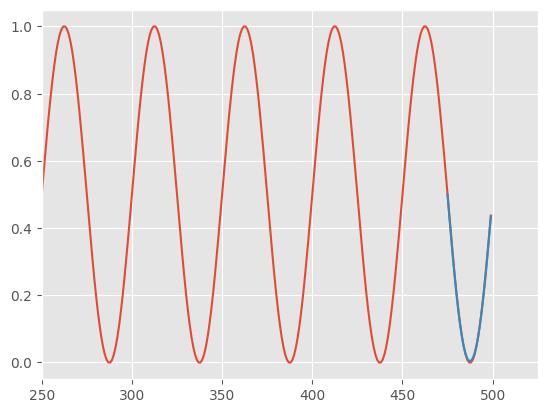

In [92]:
plt.plot(x,y)
plt.plot(np.arange(allsize-num_test,allsize),y_pred.detach())
plt.xlim([allsize-num_test*10,allsize+num_test])

RMSE: 0.003712516670721799


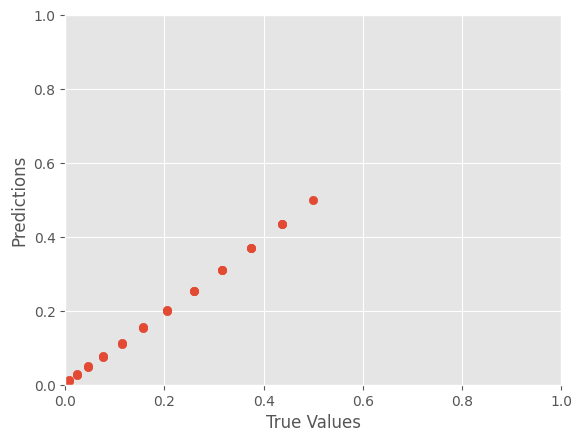

In [93]:
# y_true と y_pred を用意
y_true = y[allsize-num_test:allsize]
y_pred = y_pred.detach()

# RMSE を計算する
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# 縦軸と横軸の範囲を同じにする
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()


### ⓾未知データ予測

In [ ]:
scaled_data = scaler.fit_transform(ori_y.reshape(-1, 1))

# prediction loop
pred_days=120
#maxnum=len(scaled_data)
ii=0
jj=0
kk=0
#yy=[]
for kk in range(pred_days):
  yy=[]
  for ii in range(seq_length):
    for jj in range(num_test):
      yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
      yy.append(yy_value)
      jj+=1
  #if(ii==seq_length-1):
    #print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
  #print(yy)
  # yyをtorch.Tensorに変換
  yy_tensor = torch.tensor(yy)
  yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
  yy_tensor_reshaped = yy_tensor_reshaped.unsqueeze(dim=-1)
  #print(yy_tensor_reshaped)
  #print(yy_tensor_reshaped.size())
  # prediction
  y_pred2 = model(yy_tensor_reshaped)
  print(f"prediction:{y_pred2[-1]}")
  # y_pred2[-1]をscaled_dataの末尾に付与
  scaled_data_tensor = torch.tensor(scaled_data)
  scaled_data = torch.cat((scaled_data_tensor, y_pred2[-1].unsqueeze(0)), dim=0)
#print(scaled_data)

print(scaled_data.size())

### ⑪推論結果を保存する

In [95]:
# 推論時の結果保存
y_predout=scaled_data.detach().numpy()
y_predout2 = pd.DataFrame(y_predout)
y_predout2.to_csv("/content/gdrive/MyDrive/output/pred_sin.csv")

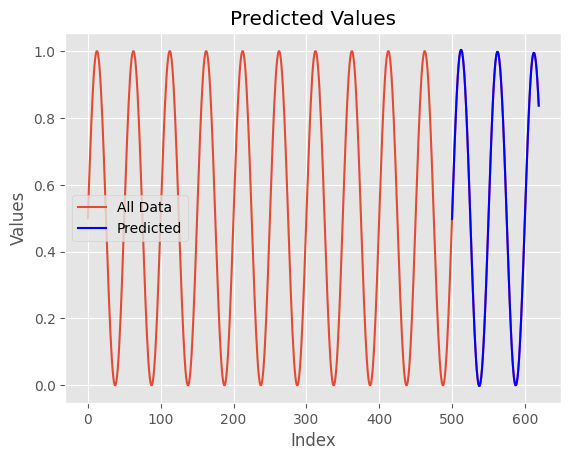

In [96]:
# pred_daysの日数に対応する部分を抽出
pred_data = y_predout2.iloc[-pred_days:]

# 全体をプロット
plt.plot(y_predout2, label='All Data')

# pred_daysの日数に対応する部分を別の色でプロット
plt.plot(pred_data, label='Predicted', color='blue')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted Values')
plt.legend()
plt.show()